# Netflix Movie Recommendations

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, r2_score
np.random.seed(0)

## Dataset Explorations
Before doing any training, I need to start off with understanding the dataset (e.g. data format, data type). I will explore it by loading it into a dataframe and visualize it later on.

In [134]:
# Only select user_id and rating. Ignore the date because it's not important in this case
df = pd.read_csv('combined_data_1.txt', header=None, names = ['user_id', 'rating'], usecols = [0,1]) 

In [135]:
df[:10]

,user_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
5,823519,3.0
6,893988,3.0
7,124105,4.0
8,1248029,3.0
9,1842128,4.0


### Subsampling the dataset for speeding up the training process
Done in terminal: 
Grabbed the first 200,000 rows of combine_data_1.txt and saved them to a new txt file (subset_cb_1.txt)

In [136]:
df_sub = pd.read_csv('subset_cb_1.txt', header=None, names = ['user_id', 'rating'], usecols = [0,1]) 

## Cleaning the dataset

Check whether there are null values. If so, drop the rows containing null values

In [137]:
pd.isnull(df_sub).any() 

user_id    False
rating      True
dtype: bool

In [138]:
clean_df_sub = df_sub.dropna()
clean_df_sub.describe()

,rating
count,199970.000000
mean,3.647642
std,1.039469
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Trying to get a feel of how the rating scores are distributed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3c410748>]], dtype=object)

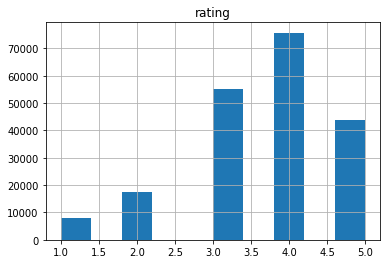

In [139]:
clean_df_sub.hist()

In [140]:
# Unique users
users = clean_df_sub['user_id'].unique()
users_count = len(users)
users_count

150676

In [141]:
# To collect unique movies, use the pre-cleaned df 
# since the rows with NaN contain movie ids in 'user_id' fields
# Then the user_ids become movie ids
movies = df_sub[df_sub.isnull().any(axis=1)]
movies[:5]

,user_id,rating
0,1:,NaN
548,2:,NaN
694,3:,NaN
2707,4:,NaN
2850,5:,NaN


### Create a new column – 'movie_id'
To assign a movie id to each row, a new list is created to be appended to df_sub.

By looking at movies dataframe above, I realized how to load the movie id. For example, row 0 to row 547 belong to movie 1; row 548 to 693 belong to movie 2, and so on.

In [143]:
indexes = [i for i in movies.index]

movie_id = 1
movie_id_column = []
for i in range(len(indexes)-1):
    movie_id_column[indexes[i]: indexes[i+1] - 1] = [movie_id] * (indexes[i+1] - indexes[i])
    movie_id += 1

In [144]:
# last movie in the data frame - movie_id = 30
# The previous for loop only assigns movie ids range from 1-29
# Thus, assign the rest by finding out the last section of rows that belong to movie 30
# This can be done by substracting the number of rows in df_sub from the last row that belongs to movie 29
last_index = len(movie_id_column)
movie_id_column[last_index: len(df_sub)] = [movie_ids[-1]] * (len(df_sub) - last_index)

In [386]:
df_sub['movie_id'] = movie_id_column
# Check every row is loaded with movie_id -- including those belong to movie 30
df_sub[:-5]

,user_id,rating,movie_id
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
6,893988,3.0,1
7,124105,4.0,1
8,1248029,3.0,1
9,1842128,4.0,1


## Recommendations

### Identifying Machine Learning Problem
It's a regression problem. Even though it looks like classification problem since the final rating scores range from 1-5 (5 classes), the original scores are floats that are rounded to integers. 

Divide original dataframe into labels (ratings) and data (user_id, movie_id):

In [147]:
clean_df_sub = df_sub.drop(indexes)
labels = clean_df_sub['rating']
data = clean_df_sub.drop('rating', 1)

Spliting the data into training set and testing set:

In [286]:
X_train, X_test, y_train, y_test = train_test_split(data, labels)

In [174]:
X_test

,user_id,movie_id
86167,1170827,28
180209,1714023,30
54827,1690682,28
79030,943441,28
67526,2620316,28
173798,2333236,30
63152,373655,28
23367,441196,16
57441,413582,28
119360,2204991,30


### Trying out different models in sklearn

Extracted random user_id, movie_id pairs from X_test

In [180]:
user_1170827 = df_sub[df_sub['user_id'] == "1170827"]
user_1170827

,user_id,rating,movie_id
86167,1170827,4.0,28
192929,1170827,4.0,30


In [181]:
user_724314 = df_sub[df_sub['user_id'] == "724314"]
user_724314

,user_id,rating,movie_id
17373,724314,3.0,8


In [182]:
user_538274 = df_sub[df_sub['user_id'] == "538274"]
user_538274

,user_id,rating,movie_id
9948,538274,2.0,8
130855,538274,4.0,30


In [183]:
user_1170827_test = user_1170827.drop(['rating'], 1)
user_724314_test = user_724314.drop(['rating'], 1)
user_538274_test = user_538274.drop(['rating'], 1)

#### Method 1: Linear Regression

In [287]:
clf = LinearRegression()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)

from sklearn.metrics import explained_variance_score
print("accuracy score: {}".format(accuracy_score(y_test, preds.round())))

accuracy score: 0.3805132718580601


#### Method 2: Gradient Boost Trees

In [288]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV

grad_boost_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=7, max_depth=10)
grad_boost_clf.fit(X_train, y_train)
preds_gb = grad_boost_clf.predict(X_test)

print("accuracy score: {}".format(accuracy_score(y_test, preds_gb)))

accuracy score: 0.39331506410897527


After trying out different combinations of parameter values, I used grid search to find the best combination.

In [268]:
params = {'n_estimators': np.arange(20, 81, 10), 'max_depth': np.arange(10, 20, 30)}
gridSearchCV = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1), param_grid=params)

gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([20, 30, 40, 50, 60, 70, 80]), 'max_depth': array([10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [269]:
gridSearchCV.grid_scores_, gridSearchCV.best_params_, gridSearchCV.best_score_

([mean: 0.39301, std: 0.00094, params: {'max_depth': 10, 'n_estimators': 20},
  mean: 0.39149, std: 0.00103, params: {'max_depth': 10, 'n_estimators': 30},
  mean: 0.39087, std: 0.00091, params: {'max_depth': 10, 'n_estimators': 40},
  mean: 0.38960, std: 0.00039, params: {'max_depth': 10, 'n_estimators': 50},
  mean: 0.38844, std: 0.00048, params: {'max_depth': 10, 'n_estimators': 60},
  mean: 0.38675, std: 0.00135, params: {'max_depth': 10, 'n_estimators': 70},
  mean: 0.38622, std: 0.00071, params: {'max_depth': 10, 'n_estimators': 80}],
 {'max_depth': 10, 'n_estimators': 20},
 0.39300692772891843)

Intersting Findings:
- With learning_rate set to 0.1, grid search shows the best result is having max_depth=10 and n_estimators=20
- After grid searching, I went back to the cell before grid search to try out different values again. But this time, I set the max_depth to 10 and had learning_rate remain 0.1. Then discovered that 7 estimators gave me the highest accuracy score: 0.3931

#### Method 3: Random Forest

In [289]:
from sklearn.ensemble import RandomForestClassifier
random_forest_clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=4, min_samples_split=50)
random_forest_clf.fit(X_train, y_train)
preds_rf = random_forest_clf.predict(X_test)
print("accuracy score: {}".format(accuracy_score(y_test, preds_rf)))

accuracy score: 0.3967155401756246


I manually tried out different combinations. Because of the grid search I did with Gradient Boost Tree, I had an idea that the number of estimators and max depth should not exceed 20. When min_samples_split reached 50, the accuracy rate hit its plateau. I tried out bigger numbers compared to 50 yet the accuracy score remained at ~ 0.40.

So far, Random Forest performs the best out of 3 methods I have tried. It's time to testing out random forest model on user_id, movie_id pairs to see results

In [186]:
random_forest_clf.predict(user_1170827_test)

array([ 4.,  4.])

In [188]:
random_forest_clf.predict(user_724314_test)

array([ 3.])

In [189]:
random_forest_clf.predict(user_538274_test)

array([ 3.,  4.])

### Please Ignore - Using Surprise to predict rating scores
I was looking up "collaborative filtering" for recommendation system and stumbled upon surprise. I tried it out to see how it worked. 

In [17]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.reader import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic

In [77]:
reader = Reader(rating_scale=(1, 5))

target_data = Dataset.load_from_df(clean_df_sub[['user_id', 'movie_id', 'rating']], reader=reader)

svd = SVD()
cross_validate(svd, target_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0008  0.9939  1.0039  0.9999  0.9982  0.9993  0.0033  
MAE (testset)     0.7900  0.7837  0.7913  0.7891  0.7846  0.7877  0.0030  
Fit time          16.36   16.67   16.94   17.01   16.82   16.76   0.23    
Test time         0.45    0.31    0.34    0.29    0.28    0.34    0.06    


{'fit_time': (16.35863995552063,
  16.66932511329651,
  16.94271421432495,
  17.01042604446411,
  16.81758213043213),
 'test_mae': array([ 0.79001068,  0.78372372,  0.79133828,  0.78905752,  0.78455376]),
 'test_rmse': array([ 1.00075735,  0.99388196,  1.0038867 ,  0.99985554,  0.99818589]),
 'test_time': (0.4504120349884033,
  0.31331610679626465,
  0.3418869972229004,
  0.2861318588256836,
  0.2836129665374756)}

In [78]:
trainset, testset = train_test_split(target_data)

In [79]:
svd.fit(trainset)
predictions = svd.test(testset)

Using Root mean squared error to evaluate the performance. Having an RMSE of 0.9976 means that it is approximately 0.9976 off with each prediction in average.

In [80]:
accuracy.rmse(predictions)

RMSE: 0.9976


0.99758988631997936

In [83]:
user_2124137 = df_sub[df_sub['user_id'] == "2124137"]
user_2124137

,user_id,rating,movie_id
97312,2124137,2.0,30


In [84]:
user_2124137['movie_id'].apply(lambda x: svd.predict(2124137, x).est)

97312    3.781999
Name: movie_id, dtype: float64

In [85]:
user_510593 = df_sub[df_sub['user_id'] == "510593"]
user_510593

,user_id,rating,movie_id
14030,510593,2.0,8
20486,510593,4.0,11
163534,510593,5.0,30


In [99]:
user_510593['movie_id'].apply(lambda x: svd.predict(510593, x).est)

14030     3.230239
20486     3.080259
163534    3.781999
Name: movie_id, dtype: float64

In [112]:
user_1271710 = df_sub[df_sub['user_id'] == "1271710"]
user_1271710

,user_id,rating,movie_id
46548,1271710,1.0,26


In [113]:
user_1271710['movie_id'].apply(lambda x: svd.predict(1271710, x).est)

46548    2.918934
Name: movie_id, dtype: float64

### Tyler's predictions

In [198]:
tyler_df = pd.read_csv('tyler_movies_train.csv', header=None, names = ['movie_id', 'rating'])
tyler_df[:5]

,movie_id,rating
0,3864,5
1,6974,5
2,14755,4
3,1770,5
4,4393,1


Since there's no 'user_id' in Tyler's data, I manually labeled him as 1 because the training models in sklearn require training and testing data to have more than one dimension. Also, the 3 methods I tried with Netflix combined data inclueded user_id. Since I am not merging Tyler's data into Netflix's, I appended user_id manually as part of the cleaning. If I needed to train Tyler's data with Netflix's, I would use clustering (e.g. KNN) to find a user that is similar to Tyler's rating/preferences. I am not sure if this is legit, but I have been thinking about it.

In [202]:
tyler_id = [1 for i in range(len(tyler_df))]
tyler_df['user_id'] = tyler_id
tyler_df[:5]

,movie_id,rating,user_id
0,3864,5,1
1,6974,5,1
2,14755,4,1
3,1770,5,1
4,4393,1,1


In [245]:
tyler_labels = tyler_df['rating']
tyler_data = tyler_df.drop(['rating'], 1)

### Split Tyler's train set into train & test for performance evalution

In [343]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(tyler_data, tyler_labels)

In [348]:
random_forest_clf2 = RandomForestClassifier(n_estimators=6, max_depth=10, random_state=6, min_samples_split=30)
random_forest_clf2.fit(X_train2, y_train2)
preds_rf2 = random_forest_clf2.predict(X_test2)
print("accuracy score: {}".format(accuracy_score(y_test2, preds_rf2)))

accuracy score: 0.8333333333333334


In [359]:
tyler_test_df = pd.read_csv('tyler_movies_test.csv', header=None, names = ['movie_id'])
tyler_test_df[:5]

,movie_id
0,8159
1,16615
2,17508
3,3446
4,14042


In [360]:
tyler_test_df['user_id'] = [1 for i in range(len(tyler_test_df))]
tyler_test_df

,movie_id,user_id
0,8159,1
1,16615,1
2,17508,1
3,3446,1
4,14042,1
5,6450,1
6,5762,1
7,3124,1
8,12546,1
9,3079,1


In [361]:
tyler_preds = random_forest_clf2.predict(tyler_test_df)
tyler_preds

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [375]:
random_forest_clf2.fit(tyler_data, tyler_labels)
preds_rf3 = random_forest_clf2.predict(tyler_test_df)
preds_rf3

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [368]:
grad_boost_clf2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=7, max_depth=40)
grad_boost_clf2.fit(X_train2, y_train2)
preds_gb2 = grad_boost_clf.predict(X_test2)

print("accuracy score: {}".format(accuracy_score(y_test2, preds_gb2)))

accuracy score: 0.16666666666666666


In [369]:
grad_boost_clf.predict(tyler_test_df)

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  4.,  3.])

In [373]:
clf2 = LinearRegression()
clf2.fit(X_train2, y_train2)
preds2 = clf.predict(X_test2)
print("accuracy score: {}".format(accuracy_score(y_test2, preds2.round())))

accuracy score: 0.0


In [371]:
clf2.predict(tyler_test_df)

array([ 4.33087445,  4.35926981,  4.36226852,  4.31504814,  4.35062965,
        4.32513561,  4.3228253 ,  4.31396686,  4.34560606,  4.31381575])

The results from 3 different models are very interesting. While they were trained with subset of combined_data, their performance came in close. However, in Tyler's case, only random foreset maintain its best performance among others.

### Train the model with entire dataset of Tyler's movie ratings (no split)

In [377]:
random_forest_clf2.fit(tyler_data, tyler_labels)
preds_rf3 = random_forest_clf2.predict(tyler_test_df)
preds_rf3

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [379]:
grad_boost_clf3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=7, max_depth=40)
grad_boost_clf3.fit(tyler_data, tyler_labels)
preds_gb3 = grad_boost_clf.predict(tyler_test_df)
preds_gb3

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  4.,  3.])

In [382]:
clf3 = LinearRegression()
clf3.fit(tyler_data, tyler_labels)
preds3 = clf.predict(tyler_test_df)
preds3

array([ 3.06956614,  3.06959522,  3.06959829,  3.06954994,  3.06958637,
        3.06956027,  3.0695579 ,  3.06954883,  3.06958123,  3.06954868])

Since I don't have the answer to validate the results, the predictions made with model trained with whole dataset are interesting. Comparing each model's first and second performances respectively, only Linear Regression's second round is different from its first round.

## Summary

When I first got the problem, I was not sure where to start since I had never coded a recommendation system. Therefore, I started with understanding the dataset itself, then looked at the final expected output. As I finished preparing the dataset for training, I decided to experiment with different models. I would not know what would work and would not work if I didn't try out different approaches. I had an idea I would use the regression approach first. 

Then I chose random forest and gradient boost tree because they worked well for other datasets in the past, including image classifications. At first, I identified the problem as a regression problem. To see if it can also be solved with classifications, I went for random forest and gradient boost tree.

With ensemble methods, the max depth parameter for both did not have to go beyond 50. When max depth went beyond 50, the accruacy decreased. I suspected that it'due to overfitting. The deeper the tree, the more details it remembers. That's not good for generalizing a model for all types of users.

In the context of predicting Tyler's ratings, since the training set contains single user's ratings, the recommendation system is content-based. As I explained in the previous section, I decided to load a made up user_id - 1 for Tyler for training purpose.

For now, the two expected outputs came from separate models. I would like to know how to train Tyler's data with the Netflix model. In other words, implementing collaborative filtering without surprise. Saw some tutorials online but I didn't fully understand them yet.